This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Support Vector Machines,<br> the Bias-Variance tradeoff<br> and a short introduction to kernel theory</div>

In the previous notebook, we saw the basic of SVM, its formulation as a quadratic optimization problem and the introduction of the regularization term C.

In this notebook, we will further study this parameter, move on to the notion of *overfit* and *underfit* and introduce kernels.

2. [Support Vector Machines in scikit-learn](#sec2)
3. [When using linear separators makes no more sense](#sec3)
4. [A word on the bias-variance tradeoff](#sec4)
5. [The kernel trick](#sec5)
    1. [The intuition of mapping to higher dimensions](#sec5-1)
    2. [The kernel trick](#sec5-2)
    3. [Positive definite kernels](#sec5-3)
6. [SVMs and kernels](#sec6)
7. [What about other uses?](#sec7)
8. [Examples](#sec8)
    1. [Spam or ham?](#sec8-1)
    2. [NIST](#sec8-2)
7. [Multi-Label Classification](#sec9)

<div class="alert alert-success"><b>In a nutshell:</b>
<ul>
<li> Support Vector Machines try to separate data by maximizing a geometrical margin
<li> They are computed offline
<li> They offer a sparse, robust to class imbalance, and easy to evaluate predictor
<li> Kernels are a way of enriching (lifting) the data representation so that it becomes linearly separable
<li> SVMs + kernels offer a versatile method for classification, regression and density estimation
<li> [Documentation in scikit-learn](http://scikit-learn.org/stable/modules/svm.html)
</ul>
</div>

# 2. <a id="sec2"></a>Support Vector Machines in scikit-learn

Let's start by loading the dataset of the previous notebook.

In [1]:
import numpy as np
%matplotlib inline

from sklearn import datasets
fig_size=(10,10)
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

res = np.loadtxt("sep_lin.csv", delimiter=',')
X = res[:,0:-1]
y = res[:,-1].astype(int)
Xblue = X[y==-1]
Xred = X[y==1]

Fortunately for us, this optimization problem is solved is three lines in scikit-learn.

SV per class: [5 5]
w_i: [ 0.44860496 -0.73539222]
w_0: [1.08402803]
Margin: 1.1608709999889961
w^T x0 + w_0: [-1.00029565]
w^T x1 + w_0: [-0.87652826]
w^T x2 + w_0: [-0.95529841]


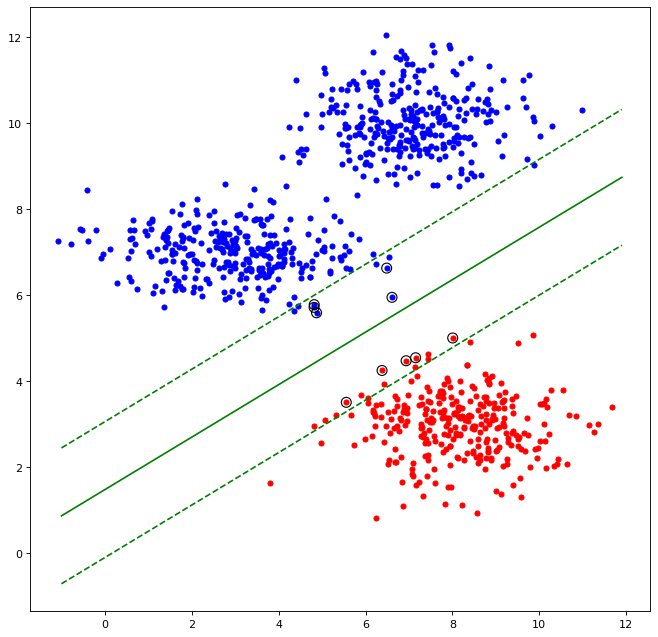

In [2]:
from sklearn import svm
mySVC = svm.SVC(kernel='linear', C=0.1)
mySVC.fit(X,y)

# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')
plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, edgecolors='k', facecolors='none');

<div class="alert alert-warning">
    
**Exercice**<br>
Try different values for $C$ in the code above to see how the margin's boundaries evolve.
</div>

Remark: since the optimization problem behind SVMs requires the knowledge of the full dataset, SVMs are necessarily an offline method.

Let's plot how the number of support vectors change with $C$.

Recall, there are 600 blue points and 300 red points.
Training at C = 0.0001
Training at C = 0.001
Training at C = 0.01
Training at C = 0.1
Training at C = 1.0
Training at C = 10.0
Training at C = 100.0
Training at C = 1000.0
Training at C = 10000.0
Training at C = 100000.0
Training at C = 1000000.0


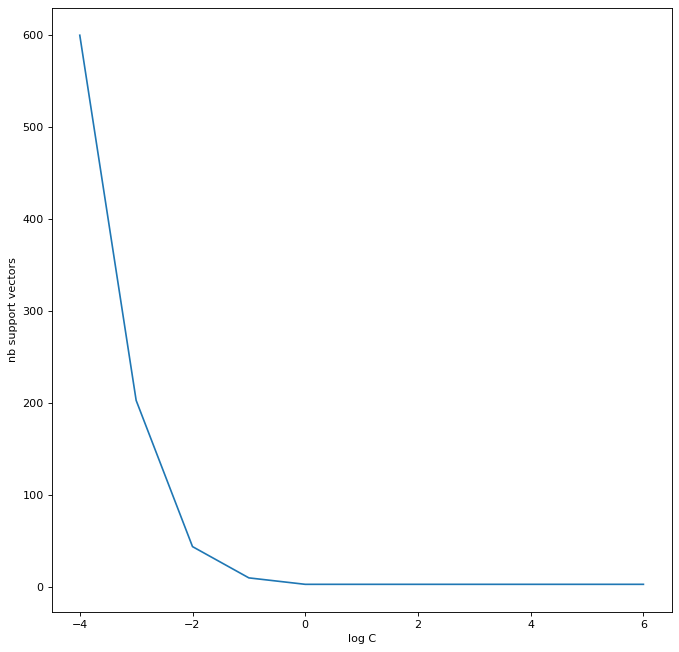

In [3]:
print("Recall, there are", Xblue.shape[0], "blue points and", Xred.shape[0], "red points.")
logC = np.arange(-4,7,1)
nbSV = np.zeros(len(logC))
for i in range(len(logC)):
    print("Training at C =", 10.**logC[i])
    mySVC = svm.SVC(kernel='linear', C=10.**logC[i])
    mySVC.fit(X,y)
    nbSV[i] = np.sum(mySVC.n_support_)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(logC,nbSV)
plt.xlabel("log C")
plt.ylabel("nb support vectors");

Let's make a few predictions.

SV per class: [1 2]
w_i: [ 0.58270058 -1.25530248]
w_0: [2.60941083]
Margin: 0.7225681979860353
w^T x0 + w_0: [-1.00018105]
w^T x1 + w_0: [1.00036678]
w^T x2 + w_0: [0.99981699]
Prediction in [2 4] = -1
Prediction in [6 2] = 1
Prediction in [10  2] = 1


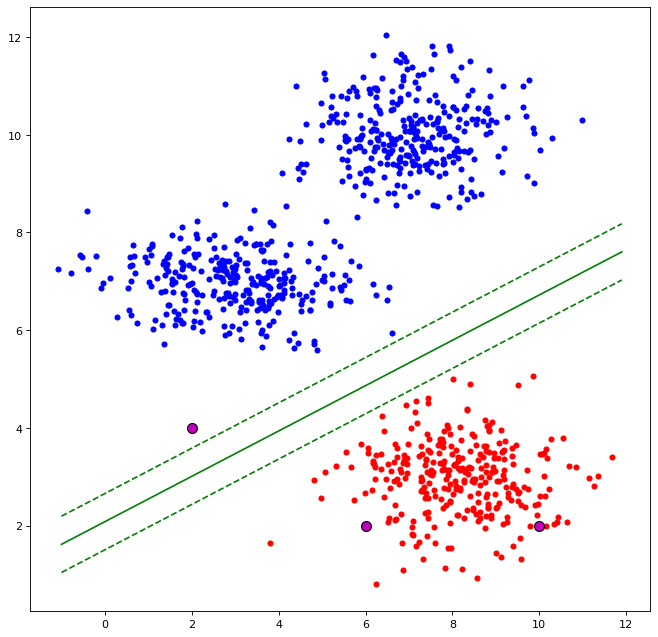

In [4]:
mySVC = svm.SVC(kernel='linear', C=1)
mySVC.fit(X,y)

# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')

# Testing data
Xtest = np.array([[2,4],[6,2],[10,2]])
Ypred = mySVC.predict(Xtest)
for i in range(Xtest.shape[0]):
    print("Prediction in", Xtest[i,:], "=", Ypred[i])

plt.scatter(Xtest[:,0],Xtest[:,1], c='m', edgecolors="k", s=80);

# <a id="sec3"></a>3. When using linear separators makes no more sense

Let's take a look at the following data. Would it make sense to try to separate the red points from the blue ones with a straight line?

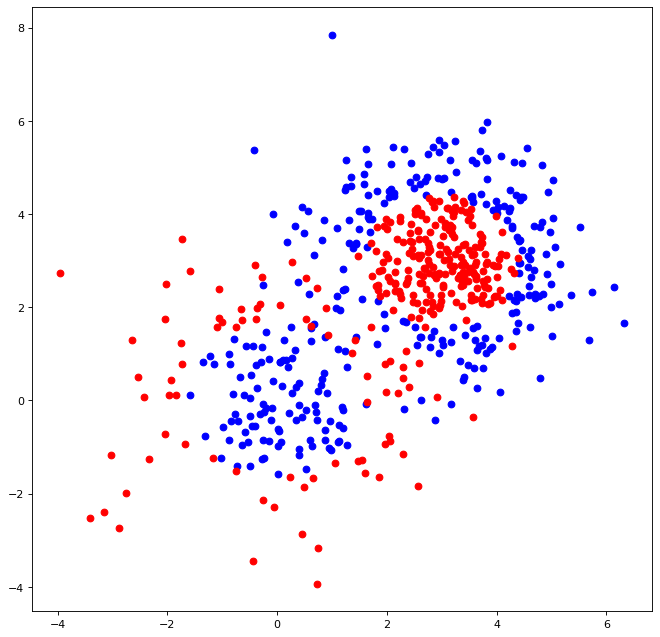

In [5]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r');

It does not look like a linear separation even makes sense. But let's try nonetheless, some optimal separating hyperplane must exist (even if it does not have great generalization properties).

<div class="alert alert-warning">
    
**Exercice:**<br>
Use scikit-learn to compute a linear Support Vector Classifier for the data above. Compute the classification score and conclude on the limits of this approach.
</div>

In [ ]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


Quite unconvincing, isn't it?

**A short metaphor before we go into more details**

<img src="img/crumpled-paper.jpg" width="400px"></img>

Take two blank sheets of paper. On the first one, draw a set of blue points. On the second, draw some red points. Now put one page on top of the other and crumple them together. The red and blue points are separable (whatever number of points there were on each sheet) , it's a certainty, since you put them on purpose on two different pieces of paper (two classes). But if you're given the current coordinates of each point, then building a relevant classifier might not be so easy. Some ideas follow from this intuition:
- Good classification might be feasible if we could build an inverse transformation ("uncrumpling") of the data that makes it linearly separable.
- Good classification functions should be able to approximate a large variety of geometric transformations of the data (this inverse transformation should be able to capture a large variety of crumpling patterns).
- A classification method that can only approximate a few geometrical transformations is prone to miss the structure of the data. We call that *underfitting*, which is due to *high bias* in the family of classification functions.
- Having a large set of uncrumpling patterns (being able to approximate many geometrical transformations of the data) comes at the price of taking the risk of picking the wrong uncrumpling pattern given the finite amount of data at our disposal. We call that *overfitting*, which is due to *high variance* in the family of classification functions.

# <a id="sec5"></a>5. The kernel trick

## <a id="sec5-1"></a> 5.1 The intuition of mapping to higher dimensions

Let's get back to the idea of giving more flexibility to our separator, since hyperplanes did not convince us they could always do the job.

To get around this problem, let's first introduce an illustrative example. The data below come from a voltage test in electronics. They indicate if a component fails or not under a certain voltage ($U$).

In [ ]:
U = np.array([[0.3, 0.7, 1.1, 1.8, 2.5, 3.0, 3.3, 3.5, 3.7]]).T
Good = np.array( [[ -1,  -1,  -1,   1,   1,   1,   1,  -1,  -1]]).T
plt.figure()
plt.scatter(U, np.zeros((U.shape[0],1)), c=Good, cmap = plt.cm.coolwarm);

<div class="alert alert-warning">
    
**Question:**<br>Does it look like these data are linearly separable?
    </div>


Some well-experienced engineer already knows that $U$ is no good criterion to split the data points into two categories with a single threshold (recall: in dimension 1, a hyperplane is a threshold). He also knows that other indicators like $V = (U-2)^2$ are not any better, but that the pair $(U,V)$ actually allows to build a separating line between points.

In [ ]:
V = (2-U)**2
plt.figure()
plt.scatter(U, V, c=Good, cmap = plt.cm.coolwarm)
XX = np.arange(np.min(U), np.max(U), 0.05)
YY = -.8+.8*XX
plt.plot(XX,YY,'g');

Our nine points are now linearly separable. But we have not introduced any additional information!<br>
<br>
Actually, the only thing we have done, is to *map* our non-separable points $x$ into **another description space**, of higher dimension, where a linear separator exists.<br>

## <a id="sec5-2"></a> 5.2 The kernel trick

Suppose we happen to know such a relevant mapping for our data $\varphi(x)=x'$, where $\varphi$ maps to a $p$-dimensional Euclidean space ($p\gg n$, possibly infinite). Then we can compute the optimal linear separator in the corresponding higher dimension description space, find its parameters $w'$ and $w'_0$, and whenever we need to make a new prediction in a point $x$, we first compute its image $x'=\varphi(x)$ and then calculate $w'^T x' + w'_0$ to know on which side of the hyperplane we stand.

But recall that: $$w' = \sum_{i=1}^N \alpha_i y_i x'_i$$

So :
\begin{align*}
w'^T x' + w'_0 & = \left(\sum_{i=1}^N \alpha_i y_i x'_i\right)^T \varphi(x) + w_0\\
& = \sum_{i=1}^N \alpha_i y_i \varphi(x_i)^T \varphi(x) + w'_0
\end{align*}

Suppose that, instead of providing us with a mapping $\varphi(x)=x'$, somebody gave us a function $K(x_1, x_2)$ that takes two points $x_1$ and $x_2$, computes their respective images $\varphi(x_1)$ and $\varphi(x_2)$ and returns the dot product:
$$K(x_1,x_2)=\varphi(x_1)^T \varphi(x_2)$$

Then making predictions would boil down to:
$$w'^T x' + w'_0 = \sum_{i=1}^N \alpha_i y_i K(x_i,x) + w'_0$$

The interesting thing is that we don't need to compute $\varphi$ anymore. The function $K$ is known as a **kernel function** and that's what we call the **kernel trick**.

It is actually possible to compute the $\alpha_i$ and $w'_0$ just using $K$ and never $\varphi$, so, as long as somebody insures that **the kernel $K$ is a dot product in some other descriptor space** we can compute the optimal separating hyperplane of our data in this space, **without ever requiring a knowledge of this descriptor space and the mapping $\varphi$**.

## <a id="sec5-3"></a> 5.3 Positive definite kernels

The main question is thus: when can we guarantee that $K$ is an acceptable kernel? It is so if it is an inner product on a (separable) Hilbert space. So in more general words, we are interested in positive, definite kernels on a Hilbert space:

<div class="alert alert-success">
$K(\cdot,\cdot)$ is a positive definite kernel on $X$ if
$$\forall n\in\mathbb{N}, x\in X^n \text{ and } c\in \mathbb{R}^n, \ \sum\limits_{i,j=1}^n c_i c_j K(x_i,x_j) \geq 0$$
</div>

We will admit that Mercer's condition below is a sufficient condition for $K$ to be a positive definite kernel:
<div class="alert alert-success">
Given $K(x,y)$, if:
$$\forall g(x) / \int g(x)^2dx <\infty, \iint K(x,y)g(x)g(y)dxdy \geq 0$$
Then, there exists a mapping $h(\cdot)$ such that:
$$K(x,y) = \langle h(x), h(y) \rangle$$
</div>

There are many kernels that have been developped in the litterature. Combined with what we have seen before, it allows to build non-linear SVMs. The nice thing is that some kernels actually map our data to a descriptor space of infinite dimension, where it is presumably a lot easier to find a separating hyperplane.

One such kernel is the so-called "radial basis kernel" which is very popular and can be written:
$$K(x_1,x_2) = e^{-\gamma \|x_1-x_2\|^2}$$

Other common kernels:
- polynomial $K(x,y)=\left(1+\langle x, y\rangle\right)^d$
- sigmoid $K(x,y) = \tanh\left(\kappa_1 \langle x, y\rangle + \kappa_2\right)$


# <a id="sec6"></a>6. SVMs and kernels

Let's practice on the last dataset with a radial basis kernel.

In [ ]:
# Plot separator, margin and support vectors
def plot_SVC(mySVC):
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
    plt.scatter(Xred[:,0],Xred[:,1],c='r')
    XX, YY = np.meshgrid(np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1), np.arange(np.min(X[:,1]),np.max(X[:,1]),0.1))
    ZZ = mySVC.decision_function(np.c_[XX.ravel(), YY.ravel()])
    ZZ = ZZ.reshape(XX.shape)
    plt.contour(XX, YY, ZZ, levels=[0],alpha=0.75)
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    cont = plt.contour(XX, YY, ZZ, levels=[-1., 0., 1.], alpha=0.75)
    plt.clabel(cont, cont.levels, inline=True, fontsize=10)
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    cont = plt.contourf(XX, YY, ZZ, alpha=0.75, cmap = plt.cm.coolwarm)

# We can play with C
mySVC = svm.SVC(kernel='rbf', C=1.)
mySVC.fit(X,y)

print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC)

A lot better isn't it? Let's play a little with the value of $C$.

<div class="alert alert-warning">
    
**Exercice:**<br>
Let's see how that SVM with the rbf kernel would do on the data from the beginning of this notebook.
</div>

In [ ]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


<div class="alert alert-warning">
    
**Exercice:**<br>
And on the "linearly separable + noise" case?
</div>

In [ ]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.0, n_samples=300, n_features=2, n_classes=1)
X1[:,0] = 3. + X1[:,0]
X1[:,1] = 6. + X1[:,1]/2.5
X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X2[:,0] = 8. + X2[:,0]
X2[:,1] = 4. + X2[:,1]
X3, y3 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X3[:,0] = 7. + X3[:,0]
X3[:,1] = 8. + X3[:,1]
X = np.concatenate((X1, X2, X3))
y = np.concatenate((y1, - y2 + 1, y3))
y = 2*y-1
X, y = shuffle(X, y)
Xblue = X[y==-1]
Xred = X[y==1]

# Display
mySVC = svm.SVC(kernel='rbf')
mySVC.fit(X,y)
print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC);

These two last experiments illustrate that introducing complex kernels such as the rbf one is sometimes detrimental.

# <a id="sec8"></a>8. Examples

## <a id="sec8-1"></a>8.1 Spam or ham?

<div class="alert alert-warning">
    
**Exercice:**<br>
Your turn to play: let's build a spam classifier using the ling-spam dataset and a linear SVM. Compute it's score on the validation dataset below.
</div>

In [ ]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

In [ ]:
print(Xtrain.shape)
print(Xtest.shape)

In [ ]:
mySVM = svm.SVC(kernel='rbf')
mySVM.fit(Xtrain, ytrain)
#plotting
plot_SVC(mySVM)

In [ ]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


<div class="alert alert-warning">
    
**Exercice:**<br>
We've trained our model in the Tf-Idf data. Let's see how the model behaves on raw word counts.
</div>

In [ ]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')

In [ ]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


<div class="alert alert-warning">
    
**Exercice:** Want to try another kernel than linear?</div>

Let's keep the tf-idf with linear SVM classifier (which seems to work better) and use it to identify which are the misclassified emails (and find the confusion matrix by the way).

In [ ]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)
spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain);

In [ ]:
# Find misclassified examples
ypredict = spam_svc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

In [ ]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_svc.predict(spam_data.tfidf[index,:]))
spam_data.print_email(index)

## <a id="sec8-2"></a>8.2. NIST

Let's evaluate SVMs on the optical character recognition task of the NIST data.

In [ ]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

print(digits.DESCR)

plt.gray();
plt.matshow(digits.images[0]);
plt.show();
plt.matshow(digits.images[15]);
plt.show();
plt.matshow(digits.images[42]);
plt.show();

In [ ]:
from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [ ]:
print(Xtrain.shape)
print(ytrain.shape)
digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
digits_svc.fit(Xtrain,ytrain)
prediction = digits_svc.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_svc.score(Xtest,ytest))

In [ ]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
    digits_svc.fit(Xtrain,ytrain)
    score += [digits_svc.score(Xtest,ytest)]
    print('*',end='')
print(" done!")

In [ ]:
print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

Let's identify which are the misclassified images (and find the confusion matrix by the way).

In [ ]:
# Retrain
Xtrain = X[:1000,:]
ytrain = y[:1000]
Xtest = X[1000:,:]
ytest = y[1000:]
digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
digits_svc.fit(Xtrain,ytrain);

In [ ]:
# Examples
N = 1053
plt.matshow(digits.images[N]) 
plt.show() 
x = digits.data[N,:]
print("prediction on image number", N, ":", digits_svc.predict([digits.data[N,:]]))
print("correct label                :", digits.target[N])

In [ ]:
# Find misclassified examples
ypredict = digits_svc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Itest = digits.images[1000:,:]
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
Imisclass = Itest[misclass,:]

In [ ]:
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

In [ ]:
# Display misclassified examples
N = 1
plt.matshow(Imisclass[N]) 
plt.show() 
print("prediction on image number", N, ":", digits_svc.predict([Xmisclass[N,:]]))
print("correct label                :", ymisclass[N])

# 9. <a id="sec9"></a> Application: Multi-label Classification (MLC)

We'll see an application which is both harder and less common than binary classification, that of **multi-label classification** (MLC).  
Given a list of possible labels, the problem consists in finding one **or more** labels associated to a data point.  
For instance, imagine extracting the keywords from a newspaper article. Possibly many labels can be associated to a text; or for example classifing the elements composing an image

Given a set of labels $\mathcal{L} = \{l_1, l_2, ..., l_k\} \in \{0,1\}^k$, we want to map elements of a feature space $\mathcal{X}$ to a subset of $\mathcal{L}$:  

$$h : \mathcal{X} \longrightarrow \mathcal{P}(\mathcal{L})$$

The two typical approaches for such problems are known as **Binary Relevance** (BR) and **Label Powerset** (LP).  

 - BR: each label in $\mathcal{L}$ is a binary classification problem, $h_{i} : \mathcal{X} \longrightarrow l_{i}, l_{i} \in \{0,1\}, i = 1, ..., |\mathcal{L}|$.

 - LP: transforms a problem of MLC into one of multiclass classification, mapping elements $x \in \mathcal{X}$ directly to $s \in \mathcal{P}(\mathcal{L})$.  
 This method becomes rapidly inapplicable as the number of $s$ grows exponentially.
 
 Many other variations exist, but for today we'll focus on BR, the most straightforward to implement.


For this exercise, we will use a biology dataset from [Elisseeff and Weston 2001]: this dataset contains micro-array expressions and phylogenetic profiles for 2417 yeast genes. Each gen is annotated with a subset of 14 functional categories (e.g. Metabolism, energy, etc.) of the top level of the functional catalogue.

<div class="alert alert-warning">**Exercice**<br>
<ul>

<li> find a suitable package to load the file at `yeast.arff`.  <br>
    Hint: <a href=https://docs.scipy.org/doc/scipy/reference/io.html>scipy.io</a> and _read the doc_.<br>
<li> Store the data in a pandas dataframe.<br>
    Hint: columns of classes will be encoded as 'utf-8', we need integers, look for 'str.decode('utf-8')'
<li> check dataset: you should have 2417 samples $\times$ 117 columns (103 features + 14 labels)
</ul>
</div>

In [ ]:
# %load solutions/code8.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


<div class="alert alert-warning">**Exercice**<br>
<ul>
<li> Manually, fit a SVM classifier for each label in the dataset
<li> Apply a cross-validation of 60 ∕ 40: 60% of datapoints to train the model, 40% to test it  <br>
   Remember: it is good practice to **randomly shuffle** the data, in case the data are ordered w.r.t. some data-dependent criterion.
<li> Report some performance measure
</ul>
</div>

In [ ]:
# %load solutions/code9.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).


**Congratulation**, you reached the end of the BE ! 